In this notebook, we will create the line mask that will be used to mask individual lines in our synthetic domain. This will allow us to create a mock test that will mimic the real-world application of having an incomplete line list in our theoretical models.

In [1]:
import numpy as np
from The_Payne import utils
from The_Payne import spectral_model
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from analysis_fns import apstarwavegrid

np.random.seed(1)

# restore The Payne default network
NN_coeffs = utils.read_in_neural_network()
w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs

# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()

In [2]:
# make mask
def make_mask(ind_ele, grad_cutoff, label):
    
    # choose a reference point
    #the format of "labels" is [Teff, Logg, Vturb [km/s],
    #              [C/H], [N/H], [O/H], [Na/H], [Mg/H],\
    #              [Al/H], [Si/H], [P/H], [S/H], [K/H],\
    #              [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],\
    #              [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],\
    #              C12/C13, Vmacro [km/s], 
    ref_labels = [4750., 2.5, 1.5,\
                  0., 0., 0., 0., 0.,\
                  0., 0., 0., 0., 0.,\
                  0., 0., 0., 0., 0.,\
                  0., 0., 0., 0., 0.,\
                  7.5, 6.]

    # choose a label to deviate
    deviate_labels = np.copy(ref_labels)
    deviate_labels[ind_ele] += 0.05

#--------------------------------------------------------------------------------------------------------------
    # scale the labels the same as it was done during the training of the network
    ref_labels = (ref_labels-x_min)/(x_max-x_min) - 0.5
    deviate_labels = (deviate_labels-x_min)/(x_max-x_min) - 0.5

    # evaluate the spectra
    ref_spec = spectral_model.get_spectrum_from_neural_net(scaled_labels = ref_labels, NN_coeffs = NN_coeffs)
    deviate_spec = spectral_model.get_spectrum_from_neural_net(scaled_labels = deviate_labels, NN_coeffs = NN_coeffs)

    # calculate the gradient spectrum
    gradient_spec = deviate_spec - ref_spec

    ### mask out pixels
    ### just to check if we masked out all features within a spectrum (that will not be good)
    #gradient_spec[spec_mask == 1.] = 0.
    #print("Number of previously masked features: ", len(start_count_mask_previous[ind_ele-3]))
    
#--------------------------------------------------------------------------------------------------------------
    # break that into features
    ind_count = 0
    counting = 0

    start_count = []
    end_count = []

    # loop over all pixels
    while ind_count < gradient_spec.size:
    
        # the start of a feature
        if gradient_spec[ind_count] < -0.001 and counting == 0:
            start_count.append(ind_count)
            counting = 1
        
        # the end of a feature
        if gradient_spec[ind_count] > -0.001 and counting == 1:
            end_count.append(ind_count)
            counting = 0
        
        ind_count += 1
        
    start_count = np.array(start_count)
    end_count = np.array(end_count)

#--------------------------------------------------------------------------------------------------------------
    # find the maximum gradient
    max_gradient = np.zeros(start_count.size)
    for i in range(start_count.size):
        max_gradient[i] = np.max(np.abs(gradient_spec[start_count[i]:end_count[i]]))

    # restrict to strong features
    choose = max_gradient > grad_cutoff
    start_count = start_count[choose]
    end_count = end_count[choose]
    max_gradient = max_gradient[choose]

    # number of features
    num_features = start_count.size

#--------------------------------------------------------------------------------------------------------------
    # discard half of the features
    if num_features >= 3:
        ind_shuffle = np.arange(num_features)
        np.random.shuffle(ind_shuffle)
        start_count_mask = start_count[ind_shuffle][:int(num_features/3)] 
        end_count_mask = end_count[ind_shuffle][:int(num_features/3)] 
    else:
        start_count_mask = []
        end_count_mask = []
        
    print(label+": Number of strong features: ", num_features, ", Number of masked features: ", len(start_count_mask))
    
    # return
    return start_count_mask, end_count_mask, start_count, end_count, gradient_spec

You can double click on the figure to get a closer look.

[C/H]: Number of strong features:  142 , Number of masked features:  47
[N/H]: Number of strong features:  93 , Number of masked features:  31
[O/H]: Number of strong features:  1 , Number of masked features:  0
[Na/H]: Number of strong features:  0 , Number of masked features:  0
[Mg/H]: Number of strong features:  13 , Number of masked features:  4
[Al/H]: Number of strong features:  4 , Number of masked features:  1
[Si/H]: Number of strong features:  13 , Number of masked features:  4
[P/H]: Number of strong features:  0 , Number of masked features:  0
[S/H]: Number of strong features:  0 , Number of masked features:  0
[K/H]: Number of strong features:  0 , Number of masked features:  0
[Ca/H]: Number of strong features:  5 , Number of masked features:  1
[Ti/H]: Number of strong features:  3 , Number of masked features:  1
[V/H]: Number of strong features:  0 , Number of masked features:  0
[Cr/H]: Number of strong features:  2 , Number of masked features:  0
[Mn/H]: Number of st

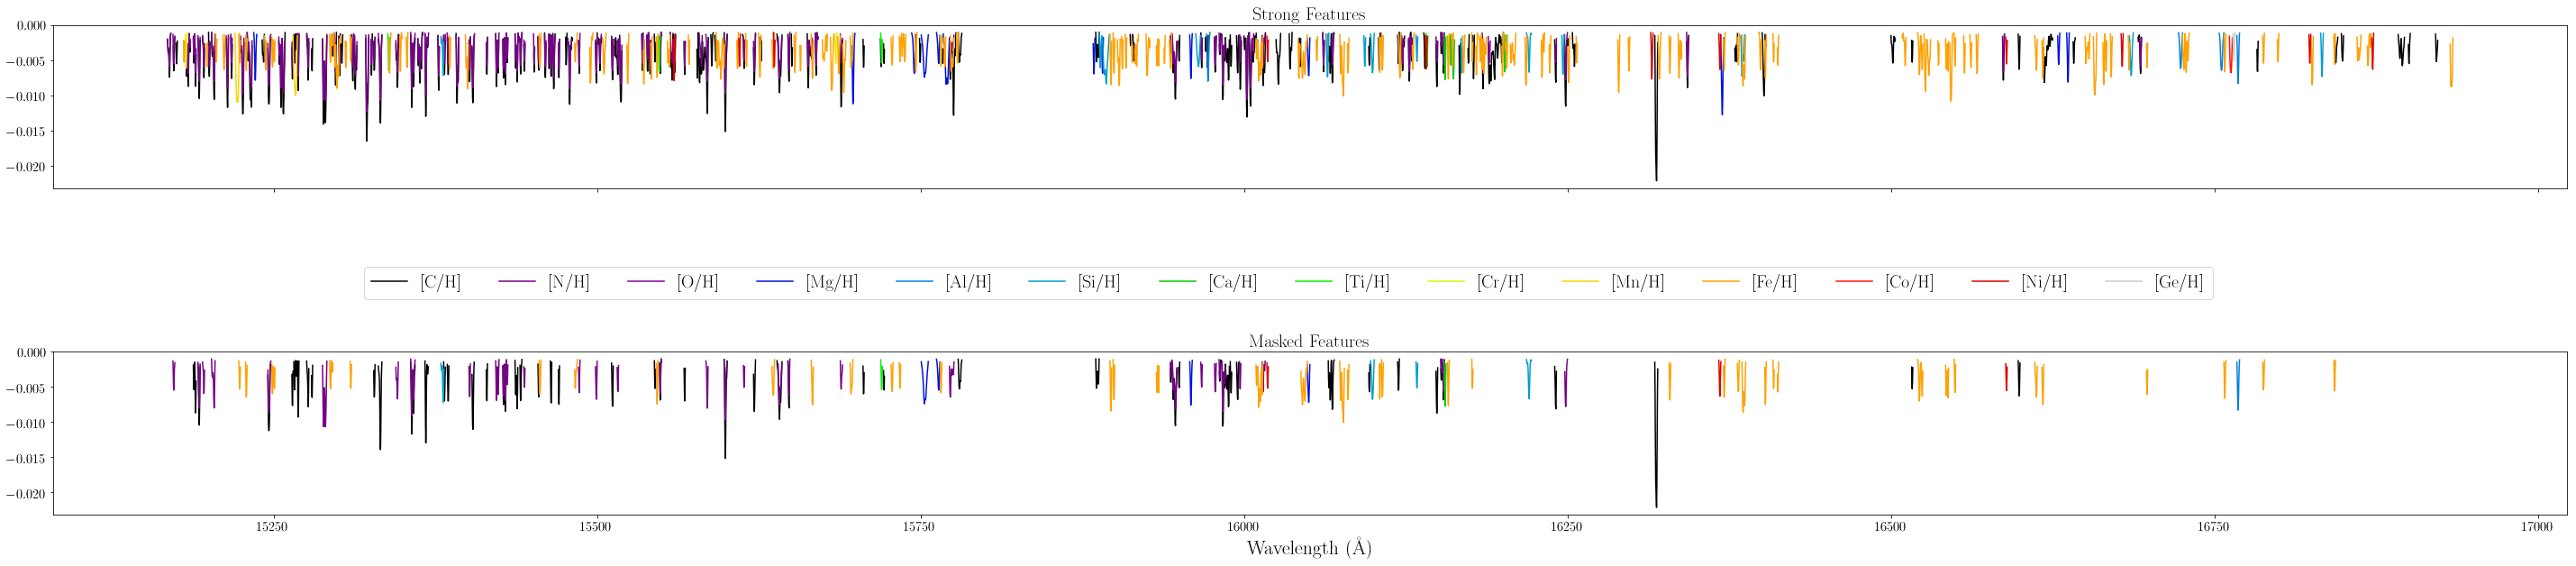

In [3]:
# initiate arrays to store results
start_count_array = []
end_count_array = []
start_count_mask_array = []
end_count_mask_array = []
gradient_spec_array = []
element_index = []
total_mask = np.zeros(7214)

#--------------------------------------------------------------------------------------------------------------
# loop over all elements
elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']

colormap = plt.cm.nipy_spectral #nipy_spectral, Set1,Paired
ele_colors = [colormap(i) for i in np.linspace(0, 1, len(elem_labels))]

fig, axes = plt.subplots(2,1,figsize=(50,10), sharex=True)
leg_count = 0
for j in range(len(elem_labels)):
    start_count_mask, end_count_mask, start_count, end_count, gradient_spec = make_mask(3+j,0.005,
                                                                                       elem_labels[j])
    start_count_mask_array.append(start_count_mask)
    end_count_mask_array.append(end_count_mask)
    start_count_array.append(start_count)
    end_count_array.append(end_count)
    gradient_spec_array.append(gradient_spec)
    element_index.append(3+j)
    
    # plot the spectrum
    for i in range(start_count.size):
        if i==0:
            axes[0].plot(wave_grid[start_count[i]:end_count[i]],
                         gradient_spec[start_count[i]:end_count[i]],
                     color=ele_colors[j], label=elem_labels[j])
        else:
            axes[0].plot(wave_grid[start_count[i]:end_count[i]],
                         gradient_spec[start_count[i]:end_count[i]],
                     color=ele_colors[j])
    
    # plot pixels that got masked out
    if len(start_count_mask) > 0:
        for i in range(start_count_mask.size):
            axes[1].plot(wave_grid[start_count_mask[i]:end_count_mask[i]],
                         gradient_spec[start_count_mask[i]:end_count_mask[i]], color=ele_colors[j])
            
            # record which pixels are to be masked
            total_mask[start_count_mask[i]:end_count_mask[i]] = 1.
            
    if len(start_count)>0:
        leg_count+=1

for ax in axes:
    ax.tick_params(labelsize=15)
axes[0].set_title('Strong Features', fontsize=20)
axes[1].set_title('Masked Features', fontsize=20)
plt.xlabel(r'Wavelength (\AA)',fontsize=22)
fig.legend(fontsize=20, loc='center', ncol=leg_count)            
print("Number of pixels masked: ", np.sum(total_mask==1.))
#plt.tight_layout()
plt.subplots_adjust(hspace=1.)
plt.show()

In [4]:
#-------------------------------------------------------------------------------------------------------------
# save the results
np.savez("../data/mock_missing_lines.npz",\
         start_count_array = start_count_array,\
         end_count_array = end_count_array,\
         start_count_mask_array = start_count_mask_array,\
         end_count_mask_array = end_count_mask_array,\
         gradient_spec_array = gradient_spec_array,\
         element_index = element_index,\
         total_mask = total_mask)